In [1]:
#| default_exp stats

# stats -- Working with all the data

> A simple package for analyzing pklmart data

In [2]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [3]:
#| export
from pklshop.data import *
from pklshop.name import *

In [4]:
table_names

['tournament',
 'match',
 'game',
 'rally',
 'shot_type_ref',
 'shot',
 'player',
 'team']

In [5]:
#! Need to think about how to store these tables so that functions can use them
#! but don't want to have to pass specific tables every time
rally = get_tab_as_df("rally")
players = get_tab_as_df("player")
game = get_tab_as_df("game")
team = get_tab_as_df("team")
match = get_tab_as_df("match")
tournament = get_tab_as_df("tournament") 

Now let's look at some overall statsitics we can get from the data.

In [6]:
#| export
def team_first_serve_win_frac(team_id):
    '''
    Takes a team id and returns that team's first serve win fraction.
    '''
    # Get all rallies where the team served the first rally of the game
    rally_fs_df = rally[(rally.rally_nbr == 1) & (rally.srv_team_id == team_id)]
    num_first_serves = len(rally_fs_df)
    #Find the number of games won by the team when they served first
    num_first_serve_games_won = sum(game[game.game_id.isin(rally_fs_df.game_id)].w_team_id == team_id)
    if num_first_serves == 0:
        return 0
    else:
        return num_first_serve_games_won/num_first_serves

def num_games_played(team_id):
    '''
    Takes a team id and returns the number of games played by that team.
    '''
    return len(game[game.w_team_id == team_id]) + len(game[game.l_team_id == team_id])

def team_win_frac(team_id):
    '''
    Takes a team id and returns that team's win fraction.
    '''
    num_games = num_games_played(team_id)
    num_wins = len(game[game.w_team_id == team_id])
    if num_games == 0:
        return 0
    else:
        return num_wins/num_games

In [7]:
team_id_test = 'T2'
team_win_frac_test = team_first_serve_win_frac(team_id_test)
print("{} won {:.2f}% of games where they served first".format(get_team_name(team_id_test), team_win_frac_test*100))

Anna Leigh Waters & Leigh Waters won 33.33% of games where they served first


Let's now look at all the games in the database and sort the teams by their win percentage when serving first.

In [8]:
fs_win_frac = [team_first_serve_win_frac(team_id) for team_id in team.team_id]
team['fs_win_frac'] = fs_win_frac
team.sort_values('fs_win_frac', ascending=False).head()

,team_id,player_id,player_seq_nbr,team_nm,maint_dtm,maint_app,create_dtm,create_app,fs_win_frac
76,T39,P61,1,Gizmo Hall & David McNally,2022-10-20 22:42:52.072401+00:00,postgres,2022-10-20 22:42:52.072401+00:00,postgres,1.0
19,T10,P18,2,Greg Dow & Anderson Scarpa,2022-07-28 21:21:24.377249+00:00,postgres,2022-07-28 21:21:24.377249+00:00,postgres,1.0
21,T11,P20,2,Chrissy Penfold & Eli Powell,2022-08-03 02:10:17.304370+00:00,postgres,2022-08-03 02:10:17.304370+00:00,postgres,1.0
79,T40,P63,2,Ryan Kane & Brandon Ward,2022-10-20 22:42:52.079848+00:00,postgres,2022-10-20 22:42:52.079848+00:00,postgres,1.0
24,T13,P23,1,Collin Johns & Ben Johns,2022-08-08 03:10:56.810337+00:00,postgres,2022-08-08 03:10:56.810337+00:00,postgres,1.0


Lastly, let's look at the win percentage when serving first, marginalized over all games

In [9]:
#| export
def get_first_serve_team(game_id: str):
    '''
    Returns the team_id of the team that served first for a given game with game_id.
    '''
    return rally[(rally.game_id == game_id) & (rally.rally_nbr == 1)].srv_team_id.values[0]

def get_frac_first_serve_wins(game_df):
    '''
    Returns the fraction of games won by the first searver for a given df of games.
    '''
    count = 0
    for game_id in game_df.game_id:
        if (game_df[game_df.game_id == game_id].w_team_id == get_first_serve_team(game_id)).values[0]:
            count +=1 
    return count/len(game_df)

In [10]:
first_serve_win_frac = get_frac_first_serve_wins(game)
print("The first serving team won {:.2f}% of games".format(first_serve_win_frac*100))


The first serving team won 54.90% of games


Let's see how Jessie Irvine compares to the average

In [11]:
#| export
def get_teams_from_player(player_id: str):
    '''
    Returns the team_ids of the teams that a player with player_id played for.
    '''
    return team[team.player_id == player_id].team_id.values

In [12]:
players.head()

,player_id,first_nm,last_nm,supp_nm,gender,dom_hand,maint_dtm,maint_app,create_dtm,create_app
0,P1,Jesse,Irvine,,None,R,2022-04-09 03:19:33.832858+00:00,postgres,2022-04-09 03:19:33.832858+00:00,postgres
1,P2,Catherine,Parenteau,,None,R,2022-04-09 03:19:33.834254+00:00,postgres,2022-04-09 03:19:33.834254+00:00,postgres
2,P3,Anna Leigh,Waters,,None,R,2022-04-09 03:19:33.835101+00:00,postgres,2022-04-09 03:19:33.835101+00:00,postgres
3,P4,Leigh,Waters,,None,R,2022-04-09 03:19:33.835814+00:00,postgres,2022-04-09 03:19:33.835814+00:00,postgres
4,P5,Lea,Jansen,,None,R,2022-05-26 00:45:11.296498+00:00,postgres,2022-05-26 00:45:11.296498+00:00,postgres


In [13]:
player_name_test = "Jesse Irvine"
# player_id_test = get_player_id_from_name(player_name_test)
player_id_test = get_player_id(player_name_test)

In [14]:
#Find the teams that Jesse Irvine played for
team_ids_test = get_teams_from_player(player_id_test)
for team_id in team_ids_test:
    print(get_team_name(team_id))

Jesse Irvine & Catherine Parenteau
Jesse Irvine & Anna Bright
Jesse Irvine & Lucy Kovalova


In [15]:
#| export
def games_played_by_team(team_id):
    '''
    Returns the number of games played by a team with team_id.
    '''
    return len(game[(game.w_team_id == team_id) | (game.l_team_id == team_id)])

In [16]:
net_games_played = sum([games_played_by_team(team_id) for team_id in team_ids_test]) #Number of games played by Ben Johns on any team
avg_first_serve_win_frac_test = sum([team_first_serve_win_frac(team_id)* games_played_by_team(team_id) for team_id in team_ids_test])/net_games_played #Average first serve win frac for Ben Johns
avg_tot_win_frac_test = sum([team_win_frac(team_id)* games_played_by_team(team_id) for team_id in team_ids_test])/net_games_played #Average total win frac for Ben Johns
print("{}'s average first serve win percentage is {:.2f}%".format(player_name_test, avg_first_serve_win_frac_test*100))
print("{}'s average overall win percentage is {:.2f}%".format(player_name_test, avg_tot_win_frac_test*100))


Jesse Irvine's average first serve win percentage is 33.33%
Jesse Irvine's average overall win percentage is 66.67%


In [17]:
colors = sns.color_palette('pastel')

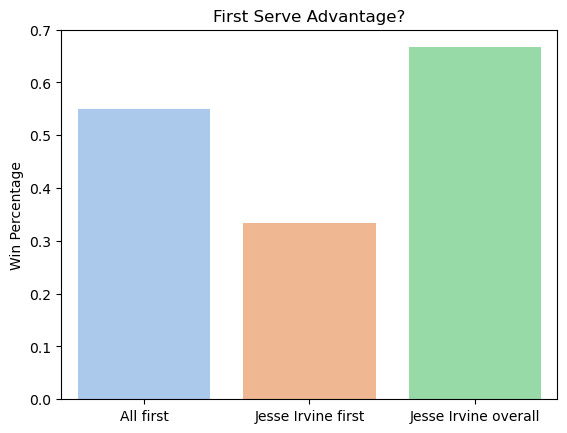

In [18]:
sns.barplot(x=['All first', player_name_test + " first", player_name_test + " overall"], y=[first_serve_win_frac, avg_first_serve_win_frac_test, avg_tot_win_frac_test], palette=colors)
plt.title("First Serve Advantage?")
plt.ylabel("Win Percentage")
# plt.savefig('figures/first_serve_win_percentage.pdf')
plt.show()

In [19]:
#| hide
import nbdev; nbdev.nbdev_export()